<h1 align="center"> Image Captioning With Attention</h1>

In this notebook you will teach network to use attention during captioning images.

Here is what we need to do:
1. Take pretrained VGG19 to build feature vectors for positions of images.
2. Stack LSTM with attention on top of that.
3. Train the model, draw attention maps.

This assignment is based on Alexander Panin's captioning assignment (https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework04/homework04_basic_part2_image_captioning.ipynb) and on the paper "Show, Attend and Tell" (https://arxiv.org/abs/1502.03044).

In [203]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
path = '/content/drive/MyDrive/DLCaption/'

In [205]:
import json

In [206]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
from tqdm import tqdm
import h5py

In [208]:
# you may need to install h5py, tqdm
#!pip install h5py tqdm
import sys
!{sys.executable} -m pip install h5py tqdm

## Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained VGG19 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py).

The whole process takes anywhere between a day on CPU and 30min on 1x GeForce GTX 1060. If you want to play with that yourself, [you're welcome](https://github.com/nadiinchi/dl_labs/blob/master/ht_attention_preprocess_data.ipynb).

Please either download data from [here](https://yadi.sk/d/KGh1SngBWH4stg) or generate it manually using the above script.

In [209]:
f = h5py.File(path+'img_codes.hdf5', 'r')
img_codes = f['data']

In [210]:
captions = json.load(open(path+'captions_tokenized.json'))

In [211]:
print("Each image code is a 512x9x9-unit tensor [ shape: %s x %s ]" % (str(len(img_codes)), str(img_codes[0].shape)))
print(img_codes[0][:3].round(2), end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 512x9x9-unit tensor [ shape: 118287 x (512, 9, 9) ]
[[[0.   0.   0.   0.   0.07 0.69 0.   0.   0.  ]
  [0.   0.24 0.   0.   0.63 1.94 1.21 0.72 0.46]
  [0.77 0.76 0.   0.   0.   0.88 1.65 2.37 1.14]
  [0.21 0.   0.   0.   2.8  3.3  2.93 6.29 3.48]
  [0.   0.   0.   0.   3.29 3.81 2.24 2.76 0.01]
  [0.   0.   0.   1.18 0.32 0.08 0.   0.   0.  ]
  [1.02 1.76 0.89 1.77 0.   0.   0.   0.   0.  ]
  [0.   1.36 0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.09 0.3  0.  ]]

 [[0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.17 0.   0.   0.   0.   0.  ]
  [0.   0.95 0.   0.   0.   0.   0.   0.   0.  ]
  [0.34 1.5  0.   0.   0.36 0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.23 0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.52 0.   0.   0.  ]
  [0.   0.34 0.   0.   0.   0.   0.86 0.34 0.  ]
  [0.   0.47 0.26 0.41 0.   0.   1.08 0.38 0.  ]]

 [[1.09 3.03 2.15 0.65 0.   0.   1.06 0.2

As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [212]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [213]:
from collections import Counter
Counter(captions[0][0])

Counter({'#END#': 1,
         '#START#': 1,
         '.': 1,
         'and': 1,
         'bins': 1,
         'bread': 1,
         'broccoli': 1,
         'closeup': 1,
         'food': 1,
         'include': 1,
         'of': 2,
         'that': 1})

In [214]:
# Build a Vocabulary
from collections import Counter
#word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
word_counts = Counter(y for z in (x for subset in captions for  x in subset) for y in z)

In [215]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [216]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [217]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   14,  287,  141,   14, 1130,  256,   62,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,  287,   62,   14, 1130,  256,  141,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,   90,  141,   14, 1291,   62,   44,    5,   14, 1287,
          13,    2,    3],
       [   1,   14, 1238, 1370,   14, 1291,   62,   14,   73,   74,   13,
           2,    3,    3],
       [   1,   14,   90,   18,   71,  342,  141,   14, 1291,   62,   14,
        1287,   13,    2]], dtype=int32)

## Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on the features from the convolutional part. 

We'll unbox the inception net later to save memory, for now just pretend that it's available.

In [218]:
import torch, torch.nn as nn
import torch.nn.functional as F

### Attention

There are $K$ objects that you can pay attention to.
Each object is characterized by the key $k_i$ and the value $v_i$.
The attention layer proceeds queries.
For the query $q$, the layer returns a weighted sum of the values of the objects, with weights proportional to the degree of key matching the query:
$$w_i = \frac{\exp(score(q, k_i))}{\sum_{j=1}^K\exp(score(q, k_j))}$$
$$a = \sum_{i=1}^K w_i v_i$$

Here we use $score(q, k) = \frac{q^Tk}{\sqrt{dim(k)}}$, where $dim(k)$ is the dimensionality of the key (which also equals the dimensionality of the query).
For more information see the paper Vaswani et al. "Attention Is All You Need", 2017.

_Hint:_ It is recommended to pay attention to the function torch.bmm, it may be useful below.

#### Score function layer

In [219]:
class ScaledDotProductScore(nn.Module):
    """
    Vaswani et al. "Attention Is All You Need", 2017.
    """
    def __init__(self):
        super().__init__()

    def forward(self, queries, keys):
        """
        queries:  [batch_size x num_queries x dim]
        keys:     [batch_size x num_objects x dim]
        Returns a tensor of scores with shape [batch_size x num_queries x num_objects].
        """
        score = torch.bmm(queries, keys.transpose(1,2)) / np.sqrt(keys.shape[2])
        return score

Test for ScaledDotProductScore

In [220]:
q = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0],
]], dtype=torch.float32)
o = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
]], dtype=torch.float32)
print(ScaledDotProductScore()(q, o))

tensor([[[0.4472, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4472, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])


#### Attention layer

In [221]:
class Attention(nn.Module):
    def __init__(self, scorer):
        super().__init__()
        self.scorer = scorer

    def forward(self, queries, keys, values):
        """
        queries:         [batch_size x num_queries x query_feature_dim]
        keys:            [batch_size x num_objects x key_feature_dim]
        values:          [batch_size x num_objects x obj_feature_dim]
        Returns matrix of responses for queries with shape [batch_size x num_queries x obj_feature_dim].
        Saves detached weights as self.attention_map.
        """
        scores = self.scorer(queries, keys)
        weights = F.softmax(scores, -1)
        self.last_weights = weights.detach()
        result = torch.bmm(weights, values)
        return result

Tests for Attention layer

In [222]:
attn = Attention(ScaledDotProductScore())

In [223]:
q = torch.randn(2, 3, 5)
k = torch.randn(2, 4, 5)
v = torch.randn(2, 4, 7)
assert attn(q, k, v).shape == (2, 3, 7)

In [224]:
q = torch.tensor([[
    [0.01],
    [1],
    [100],
]], dtype=torch.float32)
o = torch.tensor([[
    [-1],
    [0],
    [1],
]], dtype=torch.float32) * 1000
a = attn(q, o, o)
assert torch.isnan(attn.last_weights).sum() == 0
assert torch.isnan(a).sum() == 0

In [225]:
q = torch.tensor([[
    [0, 1],
    [1, 0],
]], dtype=torch.float32)
k = torch.tensor([[
    [0, 0],
    [0, 1],
    [1, 0],
]], dtype=torch.float32)
v = torch.tensor([[
    [0],
    [1],
    [2],
]], dtype=torch.float32)
a = attn(q, k, v)
print('Attention map:\n', attn.last_weights)
print('Responses:\n', a)

Attention map:
 tensor([[[0.2483, 0.5035, 0.2483],
         [0.2483, 0.2483, 0.5035]]])
Responses:
 tensor([[[1.0000],
         [1.2552]]])


### Language model

In [226]:
# Я на это потратил 2.5 дня...
# Вот это мне очень помогло (их пример): https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html
# И это: https://clay-atlas.com/us/blog/2021/08/18/pytorch-en-introduction-squeeze-unsqueeze/
# Ещё помогло проспаться...
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_channels=512):
        """ A recurrent 'head' network for image captioning. Read scheme below. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_channels, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_channels, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) # <YOUR CODE> 
            
        # attention: create attention over image spatial positions
        # The query is previous lstm hidden state, the keys are transformed cnn features,
        # the values are cnn features
        self.attention = Attention(ScaledDotProductScore()) # <YOUR CODE>
        
        # attention: create transform from cnn features to the keys
        # Hint: one linear layer shoud work
        # Hint: the dimensionality of keys should be lstm_units as lstm
        #       hidden state is the attention query
        self.cnn_to_attn_key = nn.Linear(cnn_channels, lstm_units) # <YOUR CODE>
                
        # lstm: create a recurrent core of your network. Use LSTMCell
        # Раньше у меня было только emb_size, но на опыте я понял, что нужно 640
        self.lstm = nn.LSTMCell(cnn_channels+emb_size, lstm_units) # <YOUR CODE>

        # create logits: MLP that takes attention response, lstm hidden state
        # and the previous word embedding as an input and computes one number per token
        # Hint: I used an architecture with one hidden layer, but you may try deeper ones
        # hx+emb+cnn
        self.logits_mlp = nn.Linear(lstm_units+emb_size+cnn_channels, n_tokens) # <YOUR CODE>
        
    def forward(self, image_features, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_features: torch tensor containing VGG features for each position.
                               shape: [batch, cnn_channels, width * height]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_features.mean(2))
        initial_hid = self.cnn_to_h0(image_features.mean(2))
        
        image_features = image_features.transpose(1, 2)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix) # <YOUR CODE>

        attn_map = []
        r_out = []
        # apply recurrent layer to captions_emb.
        hx, cx = initial_hid, initial_cell # 1. initialize lstm state with initial_* from above
        for capt_ix in range(captions_ix.shape[1]): # 2. In the recurrent loop over tokens:
            #print('test')
            keys = self.cnn_to_attn_key(image_features) #   2.1. transform image vectors to the keys for attention
            query, values = hx, image_features #   2.2. use previous lstm state as an attention query and image vectors as values
            #print(values.shape)
            cont_vect = self.attention(query.unsqueeze(1), keys, values) #   2.3. apply attention to obtain context vector
            attn_map.append(self.attention.last_weights) #   2.4. store attention map
            hx, cx = self.lstm(torch.cat([captions_emb[:,capt_ix], cont_vect.squeeze(1)], dim = 1), (hx, cx)) #   2.5. feed lstm with current token embedding concatenated with context vector
            r_out.append(torch.cat([hx,cont_vect.squeeze(1),captions_emb[:,capt_ix]], dim = 1)) #   2.7. store current lstm hidden state, attention response, and the previous word embedding
        # reccurent_out should be lstm hidden state sequence
        # of shape [batch, caption_length, lstm_units + cnn_channels + emb_size]
        # attention_map should be attention maps sequence
        # of shape [batch, caption_length, width * height]
        #print(torch.cat(r_out,1))
        reccurent_out = torch.stack(r_out) #<YOUR_CODE>
        attention_map = torch.cat(attn_map,1) # <YOUR CODE>
        
        # compute logits for next token probabilities
        # based on the stored in (2.7) values (reccurent_out)
        logits = self.logits_mlp(reccurent_out).transpose(0,1) # <YOUR_CODE>
        # return logits and attention maps from (2.4)
        return logits, attention_map

In [227]:
network = CaptionNet(n_tokens)

In [228]:
dummy_img_vec = torch.randn(len(captions[0]), 512, 81)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits, dummy_attention_map = network.forward(dummy_img_vec, dummy_capt_ix)

assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)
assert dummy_attention_map.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], 81)

#### Train loss function

In [276]:
def compute_loss(network, image_features, captions_ix):
    """
    :param image_features: torch tensor containing VGG features. shape: [batch, cnn_channels, width * height]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones plus 
              attention regularizer. Scalar float tensor
    """
    
    if next(network.parameters()).is_cuda:
        image_features, captions_ix = image_features.cuda(), captions_ix.cuda()
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions, attnetion map and gates for captions_ix_next
    logits_for_next, attention_map = network.forward(image_features, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    #print(logits_for_next[0])
    #print(logits_for_next.shape)
    #print(captions_ix_next.shape)
    '''
    for x in range(logits_for_next.shape[0]):
        for y in range(logits_for_next.shape[1]):
            for z in range(logits_for_next.shape[2]):
                loss += abs(captions_ix_next[x][y] - logits_for_next[x][y][z])
    '''
    #print(torch.mean(logits_for_next,2).shape)

    # Я пробовал очень много разных лоссов. Вообще это основная вещь программы, как оказалось.
    # Очень долго возился с решейпом, даже до конца не был уверен, что это правильно сработает
    # Так как это мой первый опыт работы с pytorch и тензорами
    loss = nn.CrossEntropyLoss(ignore_index = pad_ix)(logits_for_next.reshape(-1, logits_for_next.shape[2]), captions_ix_next.reshape(-1))

    # the regularizer for attention - this one requires the attention over each position to sum up to 1,
    # i. e. to look at the whole image during sentence generation process
    mask = (captions_ix_inp != pad_ix)
    masked_attention_map = attention_map * mask[:, :, None].float()
    regularizer = ((1 - masked_attention_map.sum(1)) ** 2).mean()
    
    return loss + regularizer

In [230]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.detach().cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

#### Optimizer
Create ~~adam~~ your favorite optimizer for the network.

In [231]:
# Всё-таки Адам...
# <YOUR CODE>
optimizer = torch.optim.Adam(network.parameters(), lr=0.005)

# Training

* First make train/val split without extra memory usage
* Implement the batch generator
* Than train the network as usual

In [232]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [233]:
from torch.utils.data import Dataset

class IdxDataset(Dataset):
    def __init__(self, dataset, idx):
        self.dataset = dataset
        self.idx = idx
    
    def __len__(self):
        return len(self.idx)
        
    def __getitem__(self, idx):
        return self.dataset[self.idx[idx]]

In [234]:
captions = np.array(captions)

np.random.seed(42)
perm = np.random.permutation(len(img_codes))
threshold = round(len(img_codes) * 0.1)
train_img_idx, val_img_idx = perm[threshold:], perm[: threshold]

train_img_idx.sort()
val_img_idx.sort()
train_img_codes = IdxDataset(img_codes, train_img_idx)
val_img_codes = IdxDataset(img_codes, val_img_idx)
train_captions = IdxDataset(captions, train_img_idx)
val_captions = IdxDataset(captions, val_img_idx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [235]:
from random import choice

last_batch_end = {}

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample sequential numbers for image/caption indicies (for trainign speed up)
    global last_batch_end
    random_image_ix = np.arange(batch_size, dtype='int') + last_batch_end.get(len(img_codes), 0)
    last_batch_end[len(img_codes)] = last_batch_end.get(len(img_codes), 0) + batch_size
    if last_batch_end[len(img_codes)] + batch_size >= len(img_codes):
        last_batch_end[len(img_codes)] = 0
    
    #get images
    batch_images = np.vstack([img_codes[i][None] for i in random_image_ix])
    batch_images = batch_images.reshape(batch_images.shape[0], batch_images.shape[1], -1)
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [236]:
generate_batch(img_codes, captions, 3)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0941, 0.2962, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0764, 0.3785, 0.0000],
          [1.0881, 3.0323, 2.1466,  ..., 0.9595, 1.1179, 0.9478],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0711,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.1465, 1.6479, 1.6033]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3930, 0.9311],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=3.5~3.7

In [237]:
batch_size = 64  # adjust me
n_epochs = 64    # adjust me
n_batches_per_epoch = 64  # adjust me
n_validation_batches = 8  # how many batches are used for validation after each epoch

In [238]:
from tqdm import tqdm

for epoch in range(n_epochs):
    if torch.cuda.is_available():
        network = network.cuda()
   
    train_loss=0
    network.train(True)
    with tqdm(range(n_batches_per_epoch)) as iterator:
        for _ in iterator:
            loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
            # clear old gradients; do a backward pass to get new gradients; then train with opt
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
            # <YOUR CODE>
        
            train_loss += float(loss_t)
    train_loss /= n_batches_per_epoch
        
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += float(loss_t)
    val_loss /= n_validation_batches
    
    if torch.cuda.is_available():
        network = network.cpu()

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss), flush=True)

print("Finished!")

100%|██████████| 64/64 [00:06<00:00,  9.84it/s]



Epoch: 0, train loss: 5.283155202865601, val loss: 4.52136093378067


100%|██████████| 64/64 [00:06<00:00,  9.48it/s]



Epoch: 1, train loss: 4.416125278919935, val loss: 4.302823007106781


100%|██████████| 64/64 [00:06<00:00,  9.62it/s]



Epoch: 2, train loss: 4.184452753514051, val loss: 4.156751871109009


100%|██████████| 64/64 [00:06<00:00,  9.91it/s]



Epoch: 3, train loss: 4.0837493017315865, val loss: 4.110718011856079


100%|██████████| 64/64 [00:06<00:00, 10.21it/s]



Epoch: 4, train loss: 3.9738541282713413, val loss: 3.9729870557785034


100%|██████████| 64/64 [00:06<00:00, 10.17it/s]



Epoch: 5, train loss: 3.956979937851429, val loss: 3.792421817779541


100%|██████████| 64/64 [00:06<00:00, 10.00it/s]



Epoch: 6, train loss: 3.8808557093143463, val loss: 3.909635365009308


100%|██████████| 64/64 [00:06<00:00, 10.44it/s]



Epoch: 7, train loss: 3.8681349083781242, val loss: 3.8074146509170532


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]



Epoch: 8, train loss: 3.8562955111265182, val loss: 3.8179615139961243


100%|██████████| 64/64 [00:06<00:00, 10.59it/s]



Epoch: 9, train loss: 3.837757430970669, val loss: 3.8309483230113983


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]



Epoch: 10, train loss: 3.798956662416458, val loss: 3.74164742231369


100%|██████████| 64/64 [00:06<00:00, 10.39it/s]



Epoch: 11, train loss: 3.7859689816832542, val loss: 3.821472942829132


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]



Epoch: 12, train loss: 3.7309650480747223, val loss: 3.8435835540294647


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]



Epoch: 13, train loss: 3.752901818603277, val loss: 3.7542498111724854


100%|██████████| 64/64 [00:06<00:00, 10.38it/s]



Epoch: 14, train loss: 3.7690496258437634, val loss: 3.7244586646556854


100%|██████████| 64/64 [00:06<00:00, 10.52it/s]



Epoch: 15, train loss: 3.712310206145048, val loss: 3.701746016740799


100%|██████████| 64/64 [00:05<00:00, 10.72it/s]



Epoch: 16, train loss: 3.6682428009808064, val loss: 3.687262684106827


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]



Epoch: 17, train loss: 3.734252519905567, val loss: 3.603514403104782


100%|██████████| 64/64 [00:06<00:00, 10.56it/s]



Epoch: 18, train loss: 3.6834030151367188, val loss: 3.704619377851486


100%|██████████| 64/64 [00:06<00:00, 10.52it/s]



Epoch: 19, train loss: 3.682169660925865, val loss: 3.661772280931473


100%|██████████| 64/64 [00:06<00:00, 10.55it/s]



Epoch: 20, train loss: 3.6717895306646824, val loss: 3.7251126170158386


100%|██████████| 64/64 [00:06<00:00, 10.58it/s]



Epoch: 21, train loss: 3.6446449421346188, val loss: 3.6021659076213837


100%|██████████| 64/64 [00:05<00:00, 10.83it/s]



Epoch: 22, train loss: 3.6451230943202972, val loss: 3.6779898703098297


100%|██████████| 64/64 [00:06<00:00, 10.45it/s]



Epoch: 23, train loss: 3.6441668905317783, val loss: 3.6483136117458344


100%|██████████| 64/64 [00:06<00:00, 10.49it/s]



Epoch: 24, train loss: 3.632203236222267, val loss: 3.590226888656616


100%|██████████| 64/64 [00:06<00:00, 10.61it/s]



Epoch: 25, train loss: 3.6239748783409595, val loss: 3.6785362660884857


100%|██████████| 64/64 [00:05<00:00, 10.79it/s]



Epoch: 26, train loss: 3.564980562776327, val loss: 3.6563055515289307


100%|██████████| 64/64 [00:06<00:00, 10.31it/s]



Epoch: 27, train loss: 3.5807506069540977, val loss: 3.621850401163101


100%|██████████| 64/64 [00:05<00:00, 10.86it/s]



Epoch: 28, train loss: 3.543323252350092, val loss: 3.583004802465439


100%|██████████| 64/64 [00:05<00:00, 10.76it/s]



Epoch: 29, train loss: 3.529921118170023, val loss: 3.6114284694194794


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]



Epoch: 30, train loss: 3.523220408707857, val loss: 3.560448706150055


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]



Epoch: 31, train loss: 3.539442989975214, val loss: 3.6108137667179108


100%|██████████| 64/64 [00:05<00:00, 10.88it/s]



Epoch: 32, train loss: 3.526621241122484, val loss: 3.5448109209537506


100%|██████████| 64/64 [00:06<00:00, 10.56it/s]



Epoch: 33, train loss: 3.5263236202299595, val loss: 3.591125875711441


100%|██████████| 64/64 [00:06<00:00, 10.42it/s]



Epoch: 34, train loss: 3.5185424089431763, val loss: 3.664850175380707


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]



Epoch: 35, train loss: 3.5261439830064774, val loss: 3.60279843211174


100%|██████████| 64/64 [00:06<00:00, 10.49it/s]



Epoch: 36, train loss: 3.5447870045900345, val loss: 3.6395622193813324


100%|██████████| 64/64 [00:07<00:00,  8.53it/s]



Epoch: 37, train loss: 3.528100311756134, val loss: 3.600399613380432


100%|██████████| 64/64 [00:08<00:00,  7.78it/s]



Epoch: 38, train loss: 3.499812137335539, val loss: 3.5222857296466827


100%|██████████| 64/64 [00:08<00:00,  7.67it/s]



Epoch: 39, train loss: 3.4985305555164814, val loss: 3.581552565097809


100%|██████████| 64/64 [00:08<00:00,  7.68it/s]



Epoch: 40, train loss: 3.5066723972558975, val loss: 3.488899439573288


100%|██████████| 64/64 [00:08<00:00,  7.67it/s]



Epoch: 41, train loss: 3.4877158664166927, val loss: 3.5718763768672943


100%|██████████| 64/64 [00:08<00:00,  7.54it/s]



Epoch: 42, train loss: 3.4853529520332813, val loss: 3.5696518421173096


100%|██████████| 64/64 [00:08<00:00,  7.78it/s]



Epoch: 43, train loss: 3.4923309050500393, val loss: 3.5220541656017303


100%|██████████| 64/64 [00:08<00:00,  7.73it/s]



Epoch: 44, train loss: 3.492847666144371, val loss: 3.5717495381832123


100%|██████████| 64/64 [00:08<00:00,  7.69it/s]



Epoch: 45, train loss: 3.4852936901152134, val loss: 3.597263127565384


100%|██████████| 64/64 [00:08<00:00,  7.72it/s]



Epoch: 46, train loss: 3.494099944829941, val loss: 3.600574880838394


100%|██████████| 64/64 [00:08<00:00,  7.64it/s]



Epoch: 47, train loss: 3.49157477915287, val loss: 3.577776223421097


100%|██████████| 64/64 [00:08<00:00,  7.71it/s]



Epoch: 48, train loss: 3.512183517217636, val loss: 3.584452450275421


100%|██████████| 64/64 [00:08<00:00,  7.62it/s]



Epoch: 49, train loss: 3.4637013114988804, val loss: 3.6057848632335663


100%|██████████| 64/64 [00:08<00:00,  7.76it/s]



Epoch: 50, train loss: 3.4953860230743885, val loss: 3.669831335544586


100%|██████████| 64/64 [00:08<00:00,  7.71it/s]



Epoch: 51, train loss: 3.4912429712712765, val loss: 3.52108296751976


100%|██████████| 64/64 [00:08<00:00,  7.67it/s]



Epoch: 52, train loss: 3.4166604690253735, val loss: 3.5404112637043


100%|██████████| 64/64 [00:08<00:00,  7.68it/s]



Epoch: 53, train loss: 3.433618862181902, val loss: 3.489847034215927


100%|██████████| 64/64 [00:08<00:00,  7.75it/s]



Epoch: 54, train loss: 3.414628390222788, val loss: 3.5003733336925507


100%|██████████| 64/64 [00:08<00:00,  7.58it/s]



Epoch: 55, train loss: 3.414036203175783, val loss: 3.523860454559326


100%|██████████| 64/64 [00:08<00:00,  7.99it/s]



Epoch: 56, train loss: 3.4079052172601223, val loss: 3.4197328090667725


100%|██████████| 64/64 [00:08<00:00,  7.73it/s]



Epoch: 57, train loss: 3.4319532364606857, val loss: 3.597662776708603


100%|██████████| 64/64 [00:08<00:00,  7.89it/s]



Epoch: 58, train loss: 3.390801578760147, val loss: 3.5376795828342438


100%|██████████| 64/64 [00:07<00:00,  8.26it/s]



Epoch: 59, train loss: 3.4046266563236713, val loss: 3.5110639929771423


100%|██████████| 64/64 [00:07<00:00,  8.01it/s]



Epoch: 60, train loss: 3.411737971007824, val loss: 3.5195598006248474


100%|██████████| 64/64 [00:08<00:00,  7.69it/s]



Epoch: 61, train loss: 3.4160558246076107, val loss: 3.552302837371826


100%|██████████| 64/64 [00:07<00:00,  8.04it/s]



Epoch: 62, train loss: 3.384873643517494, val loss: 3.51953187584877


100%|██████████| 64/64 [00:07<00:00,  9.09it/s]



Epoch: 63, train loss: 3.4086902141571045, val loss: 3.4111201763153076
Finished!


### Apply trained model

Let's unpack our pre-trained VGG network and see what our model is capable of.

In [239]:
from torch import nn
import torch.nn.functional as F
from torchvision.models.vgg import VGG, cfgs as VGG_cfgs, make_layers
from warnings import warn
class BeheadedVGG19(VGG):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        x_for_attn = x= self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = x = self.classifier(x)
        return x_for_attn, logits
    
features_net = BeheadedVGG19(make_layers(VGG_cfgs['E'], batch_norm=False), init_weights=False)

from torch.utils.model_zoo import load_url
features_net_url = 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
features_net.load_state_dict(load_url(features_net_url))

features_net = features_net.train(False)
if torch.cuda.is_available():
    features_net = features_net.cuda()
features_net = nn.DataParallel(features_net)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [240]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_9x9, logits = features_net(image[None])
    caption_prefix = list(caption_prefix)
    
    attention_maps = []
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        input_features = vectors_9x9.view(vectors_9x9.shape[0], vectors_9x9.shape[1], -1)
        if next(network.parameters()).is_cuda:
            input_features, prefix_ix = input_features.cuda(), prefix_ix.cuda()
        else:
            input_features, prefix_ix = input_features.cpu(), prefix_ix.cpu()
        next_word_logits, cur_attention_map = network(input_features, prefix_ix)
        next_word_logits = next_word_logits[0, -1]
        cur_attention_map = cur_attention_map[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().cpu().numpy()
        attention_maps.append(cur_attention_map.detach().cpu())
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break

    return caption_prefix, attention_maps

Here is the code which downloads image, prints different generated captions and visualize attention map.

In [241]:
from matplotlib import pyplot as plt
from skimage.transform import resize
from tempfile import mktemp
from os import remove
%matplotlib inline

# get and preprocess image
def obtain_image(filename=None, url=None):
    if (filename is None and url is None) or (filename is not None and url is not None):
        raise ValueError('You shoud specify either filename or url')
    if url is not None:
        tmpfilename = mktemp()
        !wget {url} -O {tmpfilename} -q
        img = plt.imread(tmpfilename)
        remove(tmpfilename)
    else:
        img = plt.imread(filename)
    img = resize(img, (299, 299), mode='wrap', anti_aliasing=True).astype('float32')
    return img

def show_img(img):
    plt.imshow(img)
    plt.axis('off')

def print_possible_captions(img, num_captions=10, temperature=5.):
    for i in range(num_captions):
        print(' '.join(generate_caption(img, t=temperature)[0][1:-1]))
        
def draw_attention_map(img, caption, attention_map):
    s = 4
    n = len(caption)
    w = 4
    h = n // w + 1
    plt.figure(figsize=(w * s, h * s))
    plt.subplot(h, w, 1)
    plt.imshow(img)
    plt.title('INPUT', fontsize=s * 4)
    plt.axis('off')
    for i, word, attention in zip(range(n), caption, attention_map):
        plt.subplot(h, w, 2 + i)
        attn_map = attention.view(1, 1, 9, 9)
        attn_map = F.interpolate(attn_map, size=(12, 12), mode='nearest')
        attn_map = F.interpolate(attn_map, size=(299, 299), mode='bilinear', align_corners=False)
        attn_map = attn_map[0, 0][:, :, None]
        attn_map = torch.min(attn_map / attn_map.max(), torch.ones_like(attn_map)).numpy()
        plt.imshow(img * attn_map)
        plt.title(word, fontsize=s * 4)
        plt.axis('off')

def process_image(img):
    print_possible_captions(img)
    c, am = generate_caption(img, t=5.)
    draw_attention_map(img, c[1:-1], am)

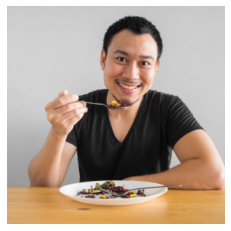

In [242]:
img = obtain_image(url="https://thecenterformindfuleating.org/resources/Pictures/asian%20man%20eating.jpg")
show_img(img)

a man sitting on a table with a plate of food on a table .
a man holding a white plate with a knife .
a man is sitting on a table with a spoon .
a man sitting on a table with a knife on the side of her plate .
a man sitting on a table with a spoon .
a man sitting on a table with a knife and a fork .
a man sitting on a table with a spoon .
a man with a white shirt and a white shirt .
a man sitting on a table with a knife and a fork .
a man sitting on a table with a spoon .


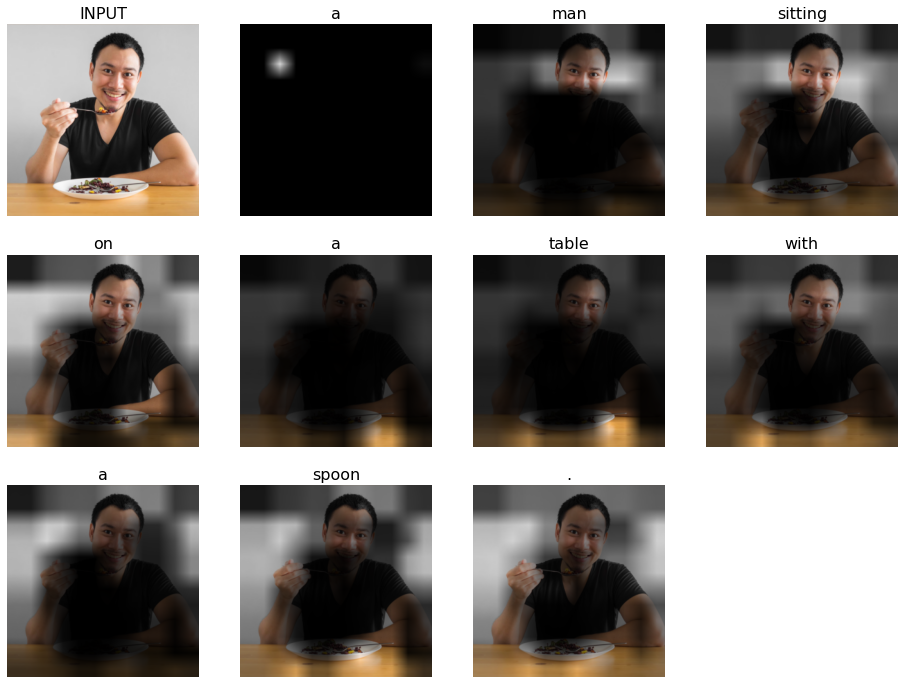

In [243]:
process_image(img)

a man riding a motorcycle through a road .
a man riding a horse through a field .
a man riding a horse on a dirt road .
a man riding a motorcycle down a dirt road .
a man riding a motorcycle down a road .
a man riding a motorcycle down a dirt road .
a man riding a motorcycle down a dirt road .
a man riding a motorcycle through a lush green countryside .
a man riding a motorcycle down a dirt road
a man riding a motorcycle down a dirt road


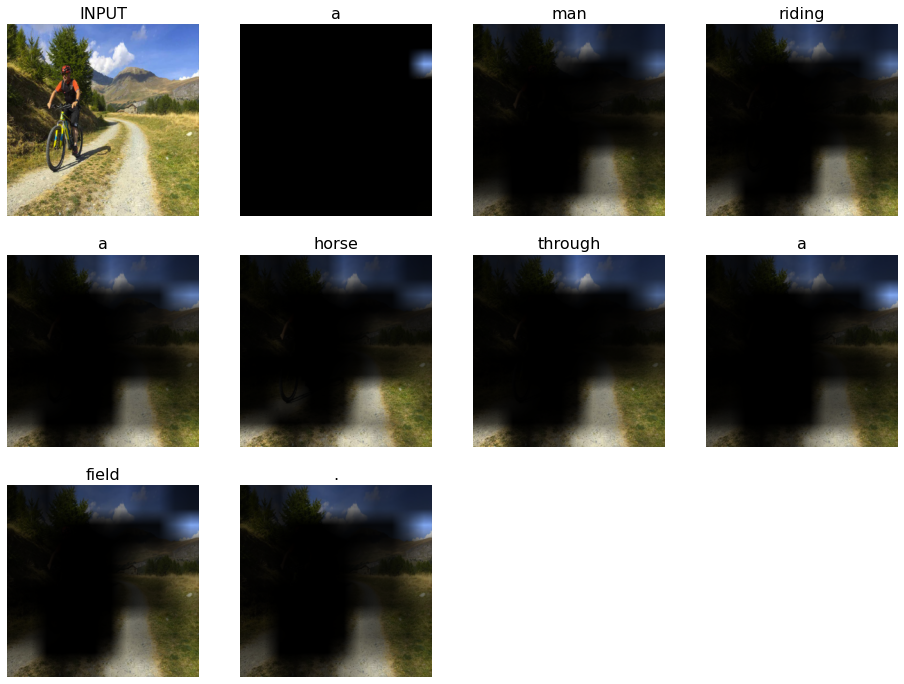

In [244]:
process_image(obtain_image(url="https://www.dimensioneattiva.it/wp-content/uploads/2016/10/Bike5.jpg"))

a cat laying on a horse in a field .
a cat laying on a horse in a field .
a cat laying on a horse on a dirt road .
a cat laying on a horse in front of a crowd .
a cat that is laying on a pair of shoes .
a cat laying on a horse in front of a crowd .
a cat laying on a horse in a field .
a cat laying on a horse in a field .
a cat laying on a horse in front of a crowd .
a cat laying on a horse in front of a crowd .


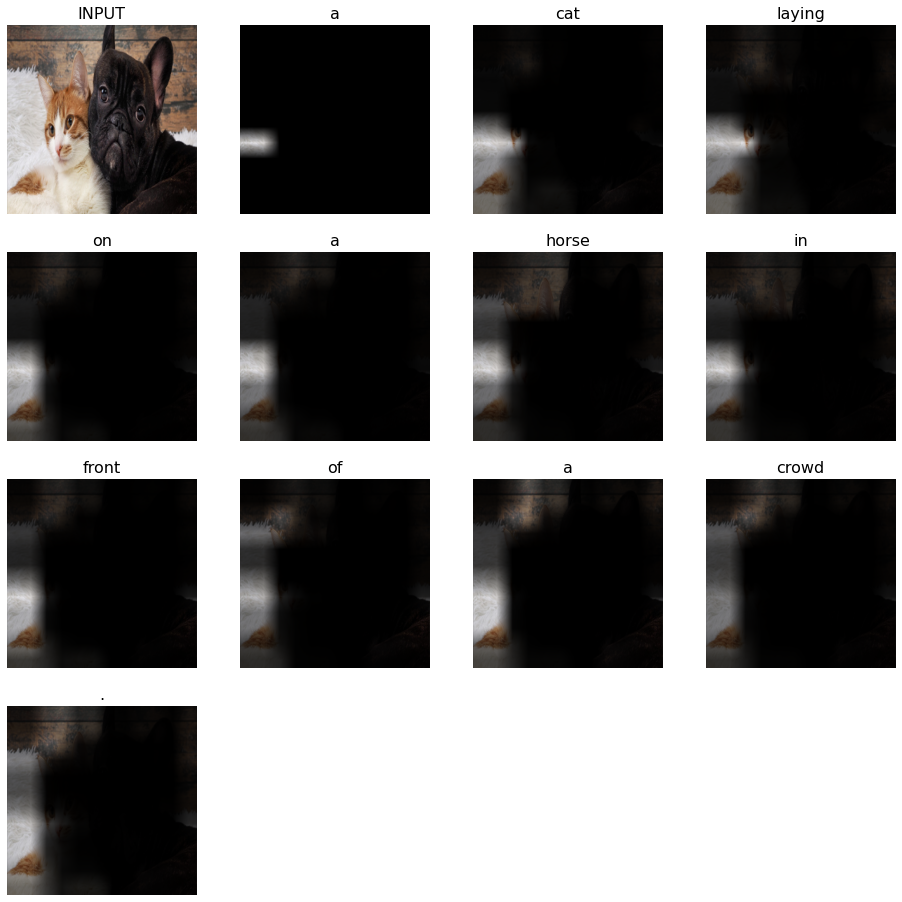

In [245]:
process_image(obtain_image(url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg"))

a man doing a jump with a skateboard on a skateboard .
a man doing a trick on a skateboard on a skateboard .
a man doing a jump on a skateboard on a skateboard .
a man doing a trick on a skateboard on a skateboard .
a man doing a trick on a skateboard on a skateboard .
a man doing a trick on a skateboard on a skateboard .
a man doing a jump on a skateboard on a skateboard
a man doing a trick on a skateboard on a skateboard .
a man doing a trick on a skateboard on a skateboard
a man doing a jump on a skateboard on a skateboard .


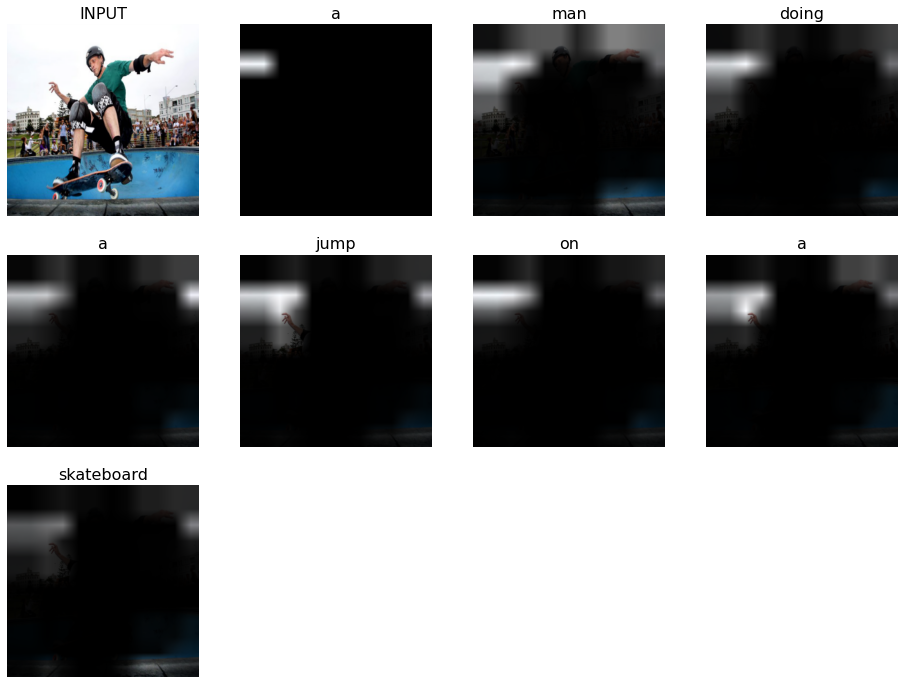

In [246]:
process_image(obtain_image(url="https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg"))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

a stuffed bear with a stuffed bear on it
a stuffed bear with a stuffed bear on a blanket on a blanket
a stuffed bear with a stuffed bear on a blanket
a stuffed bear with a stuffed bear on a blanket on a blanket .
a stuffed bear with a stuffed bear on a blanket
a stuffed bear with a stuffed bear on a blanket
a stuffed bear with a stuffed bear on a blanket .
a stuffed bear with a stuffed bear on a blanket
a stuffed bear with a stuffed bear on a blanket on a blanket
a stuffed bear with a stuffed bear on a blanket


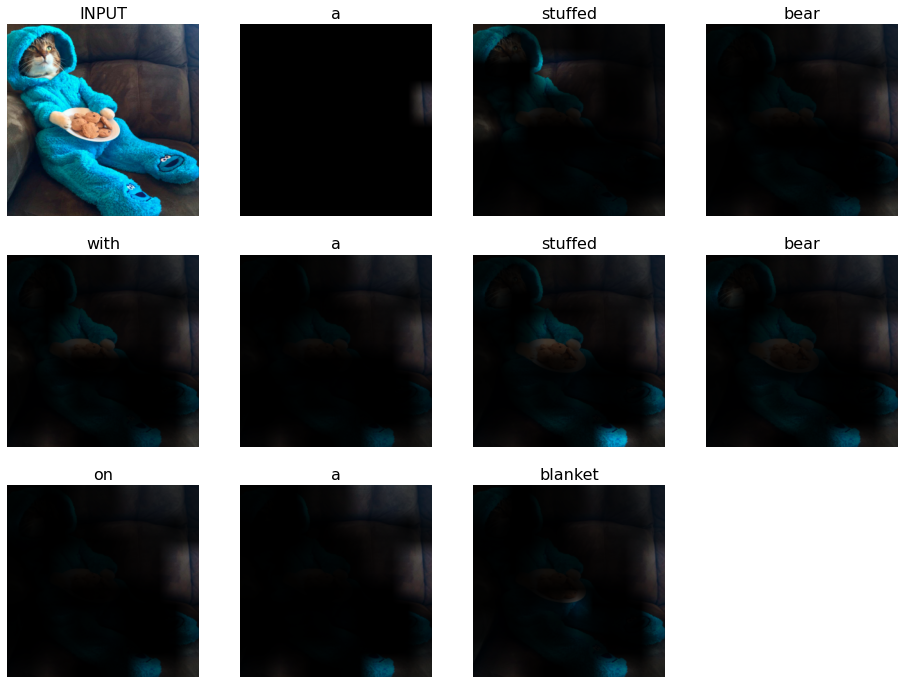

In [247]:
#apply your network on image sample you found
process_image(obtain_image(url="https://mirpozitiva.ru/wp-content/uploads/2019/11/1474111932_000.jpg"))

# Вот так кот стал плюшевым медведем...

a dog wearing a sweater and a sweater on a white blanket .
a dog laying on a white blanket on a bed
a dog wearing a sweater and a sweater on a white blanket
a dog sitting on a couch with a cat on it .
a dog laying on a cushion on a white blanket .
a dog laying on a cushion on a white blanket .
a dog with a sweater on a white blanket
a dog laying on a blanket on a couch
a dog laying on a white blanket on a couch
a dog laying on a bed with a stuffed toy .


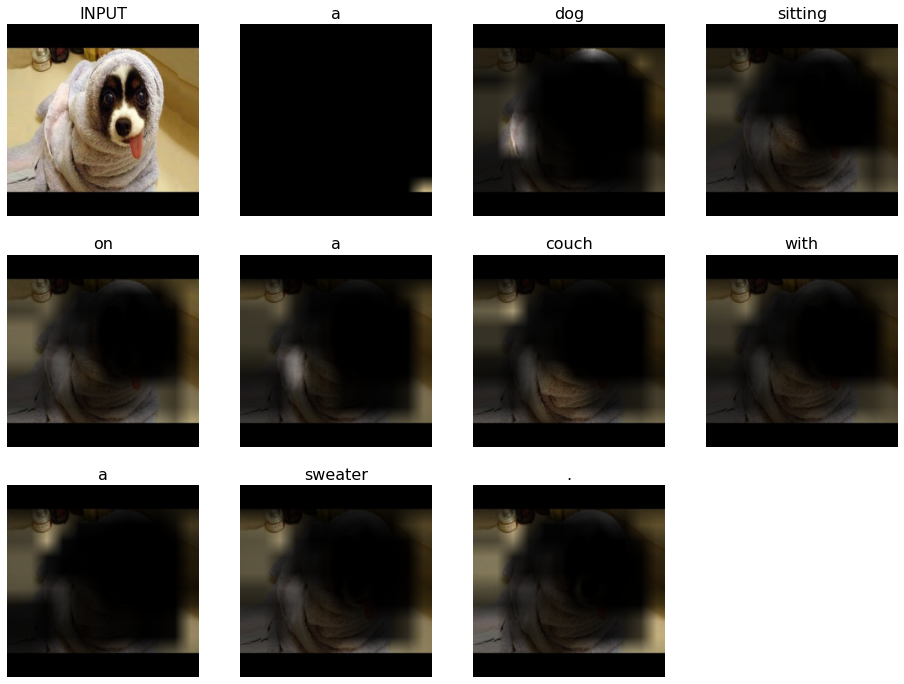

In [248]:
process_image(obtain_image(url="https://i.ytimg.com/vi/Grjk1K0YPSU/hqdefault.jpg"))

# А вот такую странную собаку смогло распознать

a dog is sitting on a leash on a leash .
a dog is standing on a sidewalk next to a dog .
a dog is standing on a leash on a leash .
a dog is standing on a sidewalk next to a suitcase .
a dog is standing on a leash on a leash
a dog is on a leash on a leash
a dog is standing on a sidewalk next to a dog .
a dog is on a leash in a car
a dog standing on a sidewalk next to a dog .
a dog is standing on a sidewalk next to a dog .


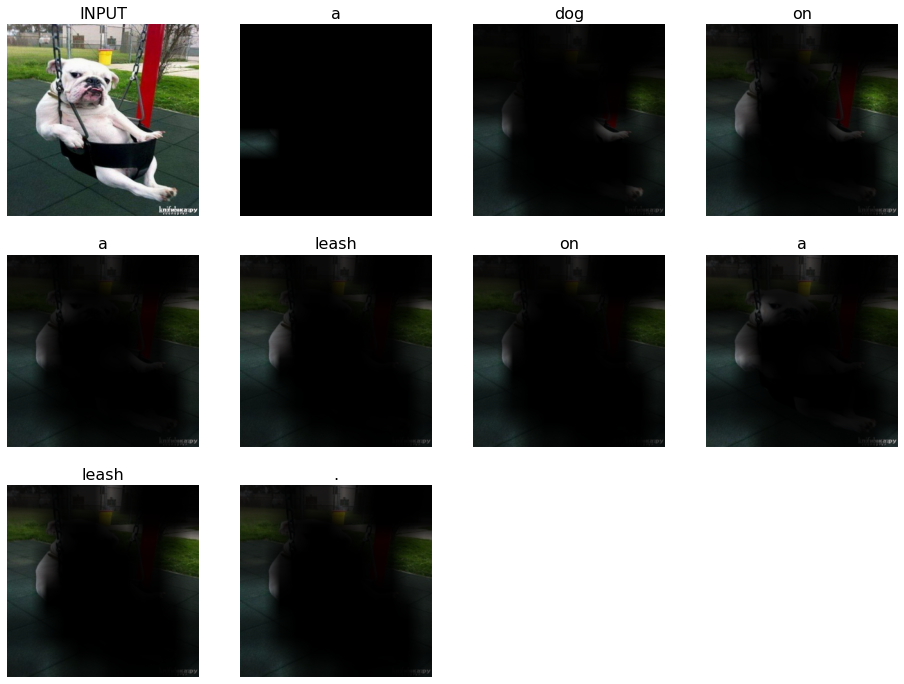

In [249]:
process_image(obtain_image(url="https://www.ptichka.ru/data/cache/2018nov/05/46/79609_73338.jpg"))

a close up of a small dog looking at a cell phone .
a close up of a small dog looking at a phone .
a close up of a small dog looking at a cell phone .
a close up of a small dog looking at a cell phone .
a close up of a small dog looking at a computer .
a close up of a small dog looking at a phone .
a close up of a small dog looking at a phone .
a close up of a small dog looking at a cell phone .
a close up of a small dog looking at a phone .
a close up of a small dog looking at a cell phone .


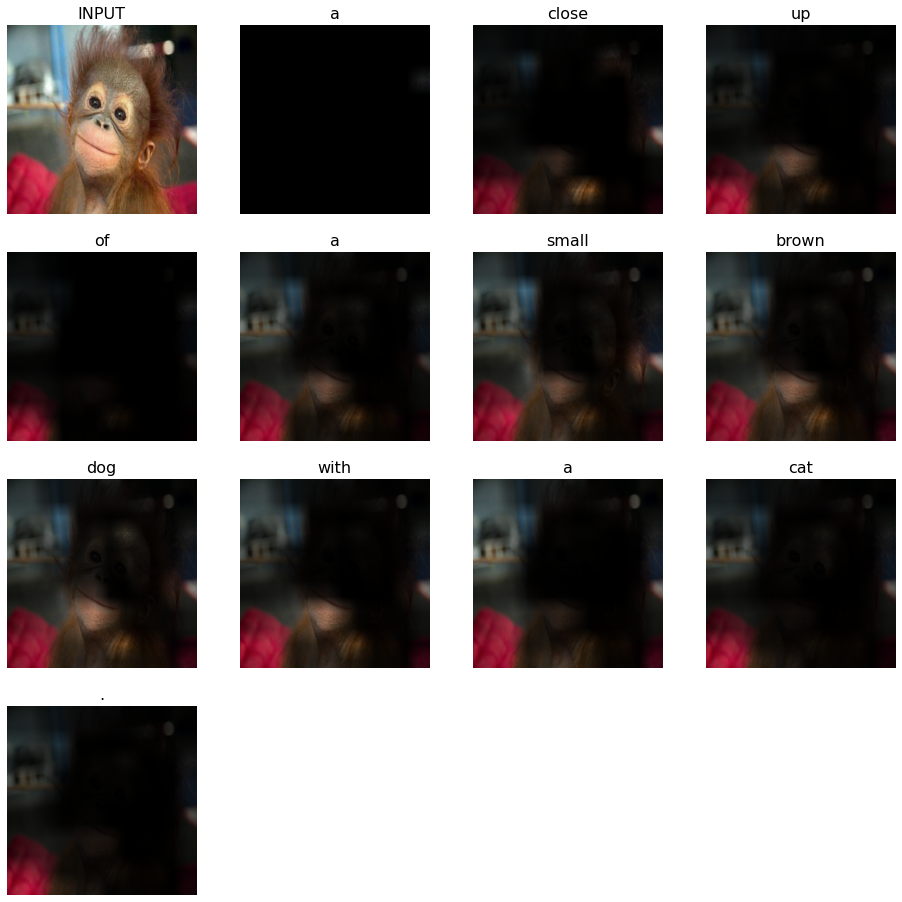

In [250]:
process_image(obtain_image(url="https://mirpozitiva.ru/wp-content/uploads/2019/11/1469620435_107513409_3.jpg"))

# Обезьянка стала собакой

a dog in a car seat up on a car
a dog is sitting on top of a car seat .
a dog sitting on top of a car seat on a leash .
a dog is sitting on the back seat of a car .
a dog sitting on top of a car seat as he looks out of the window .
a dog sitting on top of a car seat up a car .
a couple of dogs fighting over a fence .
a dog that is sitting on a car seat
a dog looking at a dog in a car seat .
a dog sitting on top of a car seat on a leash .


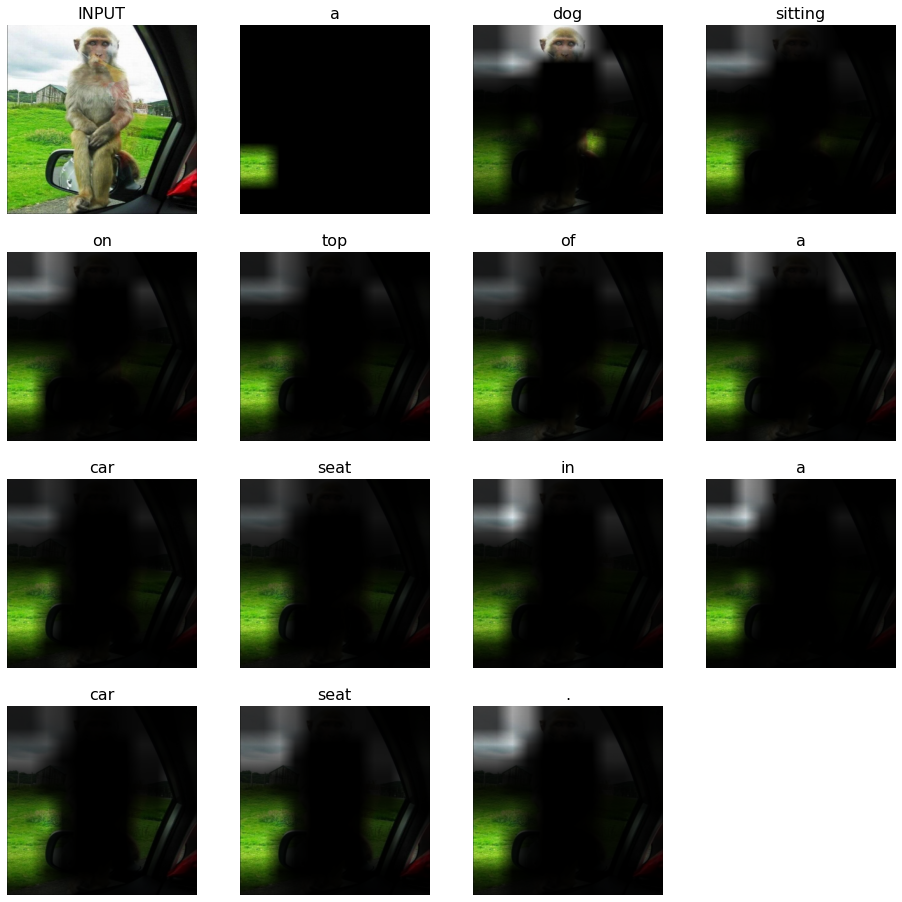

In [251]:
process_image(obtain_image(url="https://art-assorty.ru/uploads/posts/2017-09/1505630555_1326660022_6.jpg"))

# У нас сильные проблемы с обезьянками...

a boat on a mountain with mountains in the background
a train hauling a mountain with a mountain range .
a train hauling a mountain pass a mountain .
a small boat on a mountain pass by the mountain .
a boat on a mountain with mountains in the background
a boat in the water with mountains in the background
a boat in the water on a mountain pass .
a train hauling a mountain pass by side of a mountain .
a train hauling a mountain on a mountain .
a train hauling a mountain on a mountain


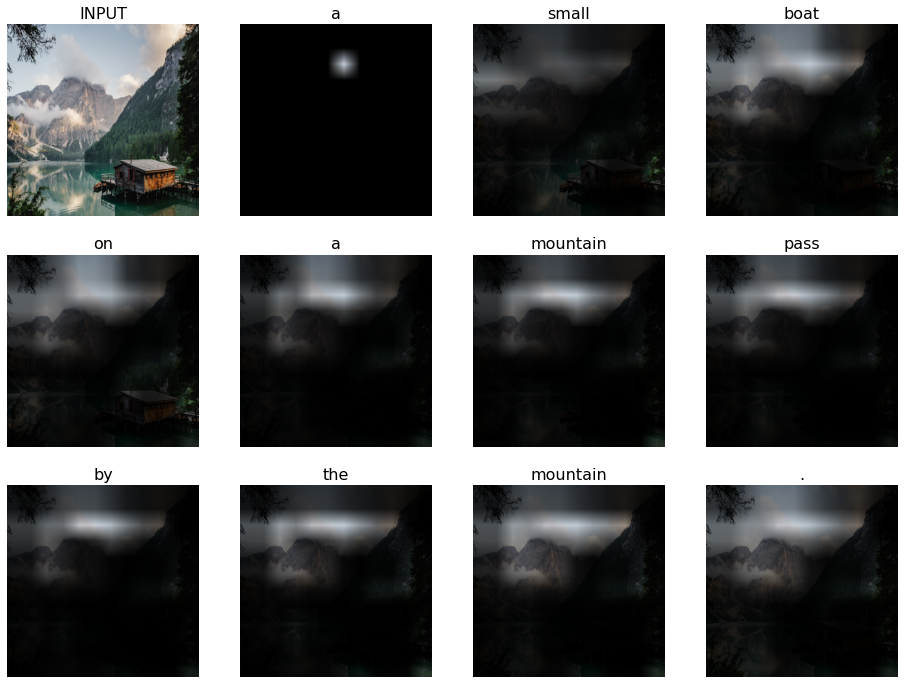

In [265]:
process_image(obtain_image(url="https://lh3.googleusercontent.com/proxy/X7fe8E5vP-GXW993XuiIupRaJbYfaR2keox1UZ3ZSNfMfn2pW3-AgEL7f5bM8ZanD52hMQmq5gop-m0ez1GEHuN0XBl95TJeyi6sc5E2IxoQZ4VyOXeIBYTTmkRvZltRp7Pf6yvoXpdHm2xAGHHD"))

# Дом на воде принял за лодку...

a person riding a bike on a dirt road .
a person riding a bike on a dirt road .
a person riding a bike on a dirt road .
a person riding a bike on a dirt road .
a person riding a bike on a dirt road .
a person riding a bike through a cloudy sky .
a person riding a bike on a dirt road .
a person riding a bike on a dirt road .
a person riding a bike on a dirt road .
a person riding a bike on a dirt road .


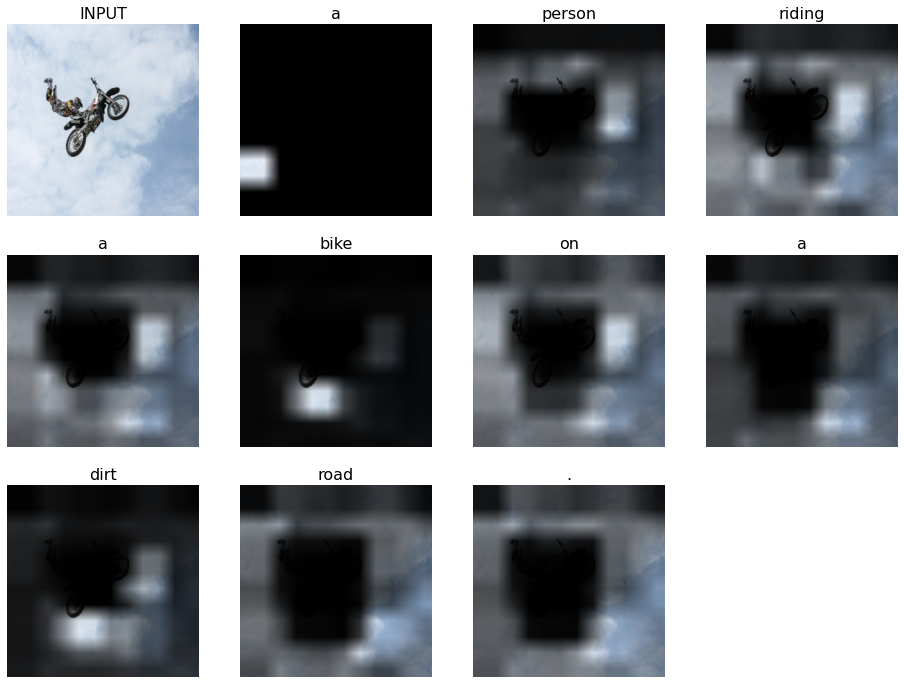

In [260]:
process_image(obtain_image(url='https://img.championat.com/s/735x490/news/big/o/m/kak-ekstremalnyj-sport-vliyaet-na-psihiku_16286889861197622367.jpg'))

a man on a bike with a dog on the back .
a man riding a bike on a dirt road .
a man on a bike with a dog on top of it .
a man riding a bike on top of a dirt road .
a man on a bike with a dog on the back .
a man on a bike with a dog on it
a man riding a bike on top of a dirt road .
a man on a bike with a dog on the back .
a man on a bike with a dog on the back .
a man on a bike with a dog on the back .


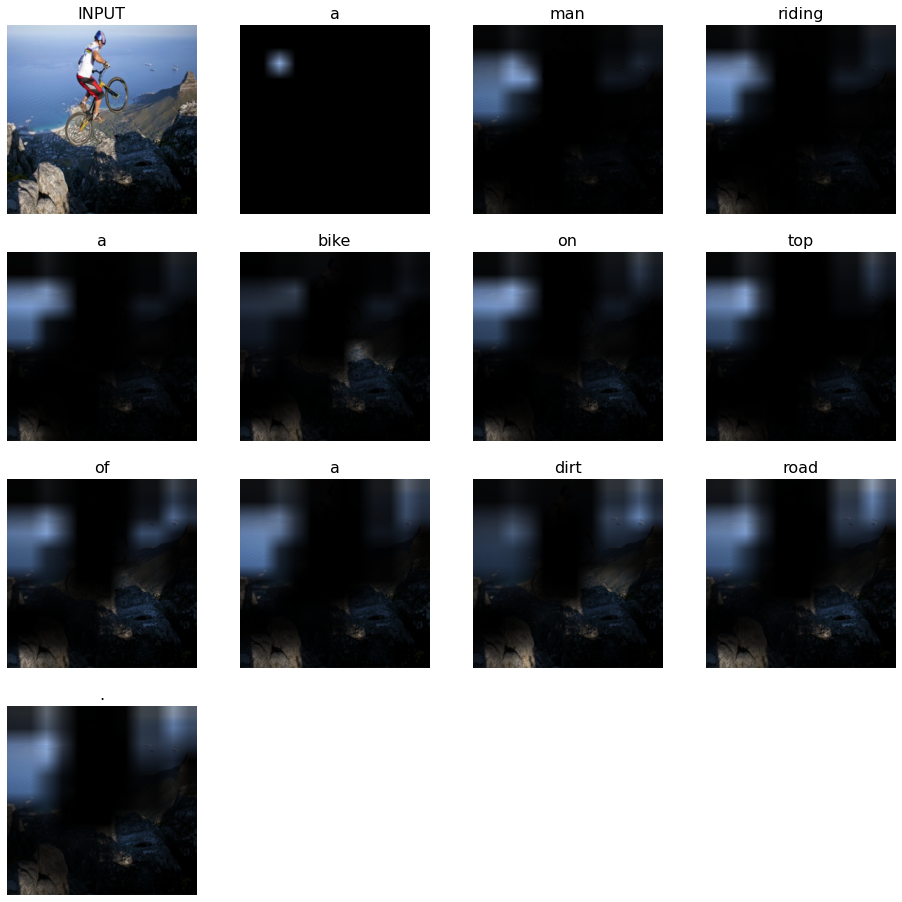

In [254]:
process_image(obtain_image(url="https://cdn.hype.tech/2000x/file/2018/10/25/hype-ru-prevyu-for-0l0LmvvCE5R5UEkTv0j48X.jpeg"))

a man flying a kite on a field
a man flying a kite on a field
a man flying a kite on a field
a man flying a kite on a field of grass .
a man flying a kite in a field .
a man flying a kite on a field .
a man flying a kite while standing in a field .
a man flying a kite on a field .
a man flying a kite on a field
a man flying a kite on a field


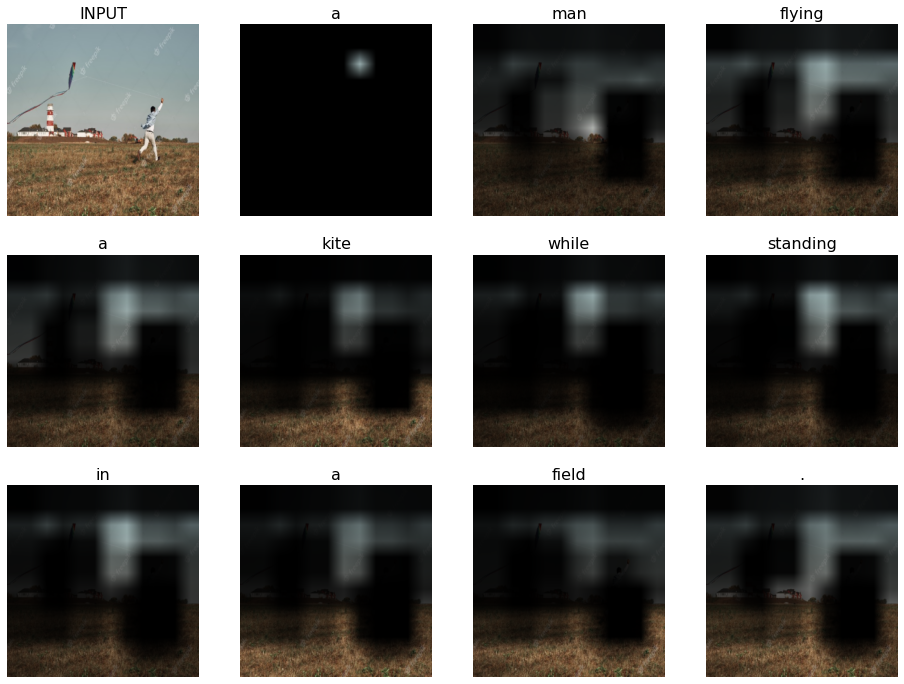

In [273]:
process_image(obtain_image(url="https://image.freepik.com/free-photo/the-man-plays-with-a-kite-in-the-field-lighthouse-in-the-background-autumn-time-outdoor-games_100894-2458.jpg"))

# Даже поверх вотермарки распознало

a dog laying on a floor with a dog on the ground .
a dog lying on a floor with a dog on its paws .
a dog in a black hoodie running with a dog .
a dog laying on a floor with a dog in his mouth .
a dog lying on a floor with a dog .
a dog laying on a floor with a dog on its back .
a dog laying on a floor with a dog on its back .
a dog laying on a floor with a dog on its back .
a dog laying on a floor with a dog in his mouth .
a dog laying on a floor with a dog on its back .


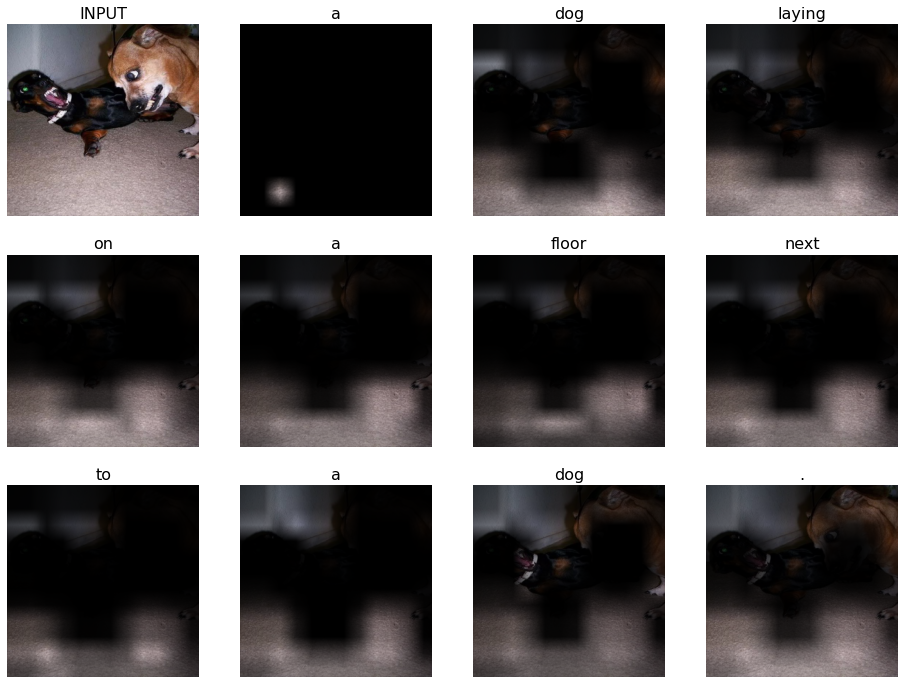

In [274]:
process_image(obtain_image(url="https://cdn.trinixy.ru/pics5/20120413/dogs_are_stupid_67.jpg"))
# Это больше всего мне понравилось, потому что я сам не заметил, что одна собака лежит

### Conclusion
Мне очень понравилось данное задание!  <br>
Да, я не дошёл до допов, но это была моя первая самостоятельная работа с pytorch на таком уровне.<br>
Самым сложным был CaptionNet на который я убил примерно 3 дня, но благодаря ему я наконец понял, как всё это работает.

Самым неожиданным открытием стала такая значимость в выборе loss-функции. Раньше я не придавал большого значения, думал, что их столько только из-за удобства и что сильно оно не может влиять.<br>
Все мои неверные идеи разрушились, когда я изначально написал свой лосс и сеть начала выдавать самую настоящую кашу, хотя train проходил хорошо, и loss был на уровне 3-3.5. Тогда пришлось гуглить torch.optim и долго-долго изучать и пытаться привести входные данные к нужному формату для loss.

В общем, я до сих пор в эйфории от того, что только что сделал и что оно работает.<br>

Я попробую улучшить сеть уже для себя, потому что на оценку я не успеваю, но это занятие очень интересное! Спасибо Вам большое!

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention over the generated part of the sentense.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563